In [2]:
import matplotlib.pyplot as plt
import numpy as np
import re
import pandas as pd

HARDWARES = ["A100", "RTX", "MI250x"]
P         = np.arange(2, 7)
CG_FOLDER = "../experiments/stiff_cg"
PERFORMANCE_FOLDER = "../experiments/mat_free3D_stiffness_"
SCALAR_TYPES = ["float32", "float64"]


In [3]:
plt.rcParams.update({
    'font.family': 'serif',
    'mathtext.fontset': 'cm',
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 11,
    'figure.titlesize': 18
})

In [4]:
def parse_cg_file(filename):
    pcg = np.nan; cg = np.nan
    with open(filename, 'r') as f:
        for line in f:
            m = re.search(r'Number of GPU PCG iterations\s*([0-9.]+)', line)
            if m: pcg = float(m.group(1))
            m = re.search(r'Number of GPU CG iterations\s*([0-9.]+)', line)
            if m: cg  = float(m.group(1))
    return pcg, cg

def parse_gdofs_file(filename):
    sf_otf = np.nan
    sf = np.nan
    baseline = np.nan
    with open(filename, 'r') as f:
        for line in f:
            m1 = re.search(r'Tuned Mat-free action Gdofs/s:\s*([0-9.]+)', line)
            if m1:
                sf_otf = float(m1.group(1))
            m2 = re.search(r'Baseline Mat-free action Gdofs/s:\s*([0-9.]+)', line)
            if m2:
                baseline = float(m2.group(1))
            m3 = re.search(r'SF Mat-free action Gdofs/s:\s*([0-9.]+)', line)
            if m3:
                sf = float(m3.group(1))
    return sf, sf_otf, baseline

In [5]:
# Load CG data
b_pcg, b_cg = zip(*(parse_cg_file(f'{CG_FOLDER}/log_bernstein_{i}.txt') for i in P))
g_pcg, g_cg = zip(*(parse_cg_file(f'{CG_FOLDER}/log_gll_{i}.txt')       for i in P))

# Create CG DataFrame
cg_df = pd.DataFrame({
    'P': list(P),
    'Bernstein_PCG': b_pcg,
    'Bernstein_CG': b_cg,
    'GLL_PCG': g_pcg,
    'GLL_CG': g_cg
})

# Get hardware data
performance_data = []

for scalar_type in SCALAR_TYPES:
    for hardware in HARDWARES:
        try:
            sf_vals, sf_otf_vals, base_vals = zip(*(parse_gdofs_file(f'{PERFORMANCE_FOLDER}{hardware}/log_float32_{i}.txt') for i in P))
            
            # Add to performance data list
            for i, p_val in enumerate(P):
                performance_data.append({
                    'P': p_val,
                    'Hardware': hardware,
                    'ScalarType': scalar_type,
                    'SF': sf_vals[i],
                    'SF_OTF': sf_otf_vals[i],
                    'Baseline': base_vals[i]
                })
        except FileNotFoundError:
            print(f"File not found for {hardware} with scalar type {scalar_type}. Skipping...")

# Create performance DataFrame
perf_df = pd.DataFrame(performance_data)

File not found for A100 with scalar type float32. Skipping...
File not found for MI250x with scalar type float32. Skipping...
File not found for A100 with scalar type float64. Skipping...
File not found for MI250x with scalar type float64. Skipping...


In [6]:
# Display the CG DataFrame
print("CG Data:")
display(cg_df)

# Display the Performance DataFrame
print("\nPerformance Data:")
display(perf_df)

CG Data:


,P,Bernstein_PCG,Bernstein_CG,GLL_PCG,GLL_CG
0,2,2535.0,1856.0,1278.0,1545.0
1,3,1032.0,2363.0,2460.0,4577.0
2,4,1114.0,1332.0,3602.0,4157.0
3,5,1829.0,2117.0,4001.0,5819.0
4,6,3397.0,2423.0,7922.0,9117.0



Performance Data:


,P,Hardware,ScalarType,SF,SF_OTF,Baseline
0,2,RTX,float32,1.05385,1.893560,1.293650
1,3,RTX,float32,1.46810,2.075620,1.592560
2,4,RTX,float32,1.71372,1.415700,1.187090
3,5,RTX,float32,1.79453,0.862710,0.294125
4,6,RTX,float32,2.01314,0.603503,0.167284
5,2,RTX,float64,1.05385,1.893560,1.293650
6,3,RTX,float64,1.46810,2.075620,1.592560
7,4,RTX,float64,1.71372,1.415700,1.187090
8,5,RTX,float64,1.79453,0.862710,0.294125
9,6,RTX,float64,2.01314,0.603503,0.167284


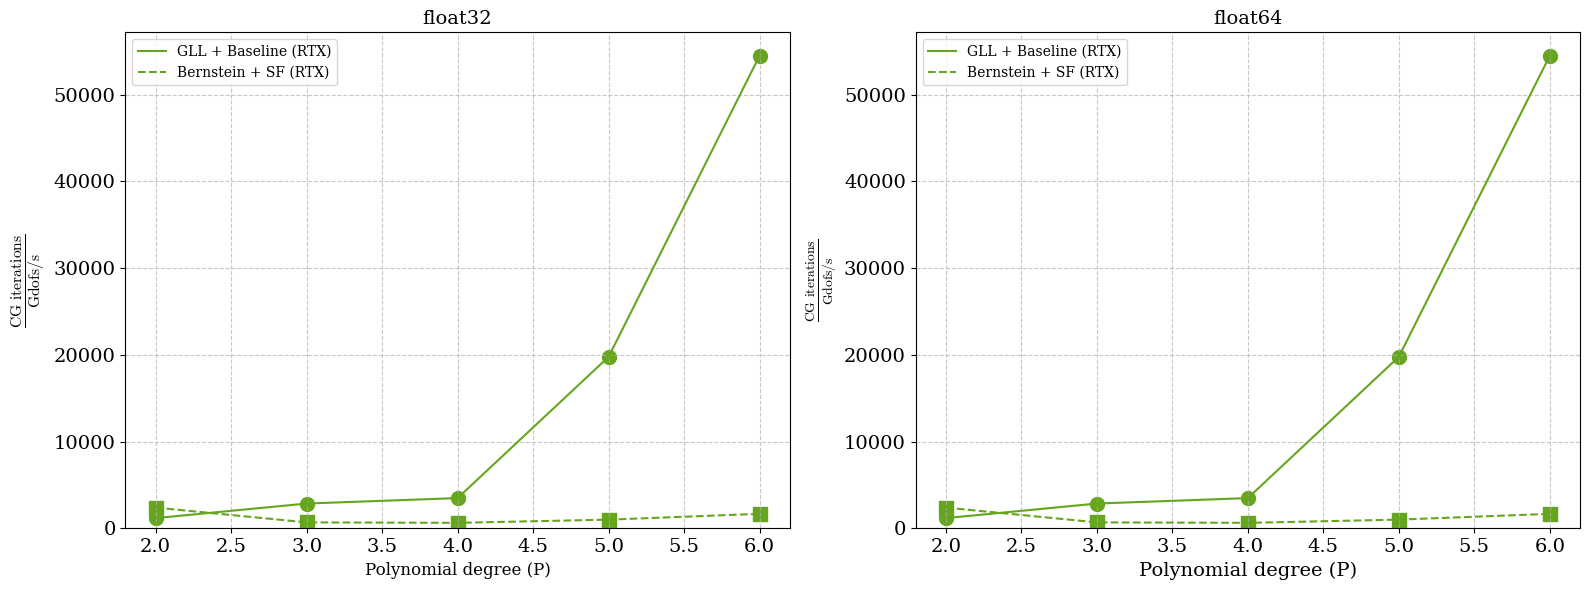

In [7]:
# Plot: CG iterations / gdofs/s = [CGdofs * s]
# For baseline algorithm, GLL and Bernstein are available. The best is always GLL.
# For SF, SF_OTF, only Bernstein is available

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
markers = ['o', 's', '^', 'D', 'x']
# Use a different colormap with more distinct colors for hardware types
colors = plt.cm.Dark2(np.linspace(0, 1, len(HARDWARES)))

# Collect all y values to determine common y limits
all_y_values = []

# Plot for float32
ax = axes[0]
float32_df = perf_df[perf_df['ScalarType'] == 'float32']

# For each hardware type
for hw_idx, hardware in enumerate(HARDWARES):
    hw_df = float32_df[float32_df['Hardware'] == hardware]
    
    # For GLL with baseline (best baseline scenario)
    gll_baseline_vals = []
    for p_val in P:
        gll_cg = cg_df.loc[cg_df['P'] == p_val, 'GLL_CG'].values[0]
        hw_p_df = hw_df[hw_df['P'] == p_val]
        if len(hw_p_df) > 0 and not np.isnan(gll_cg):
            baseline = hw_p_df['Baseline'].values[0]
            if not (np.isnan(gll_cg) or np.isnan(baseline)):
                y_val = gll_cg / baseline
                all_y_values.append(y_val)
                gll_baseline_vals.append((p_val, y_val))
    
    # Plot points and line if we have data
    if gll_baseline_vals:
        p_vals, y_vals = zip(*gll_baseline_vals)
        ax.scatter(p_vals, y_vals, color=colors[hw_idx], marker=markers[0], s=100)
        ax.plot(p_vals, y_vals, color=colors[hw_idx], 
                label=f'GLL + Baseline ({hardware})', linestyle='-')
    
    # For Bernstein with different approaches
    methods = [
        # ('Bernstein_CG', 'Baseline', 'Bernstein + Baseline'),
        ('Bernstein_PCG', 'SF', 'Bernstein + SF'),
        # ('Bernstein_PCG', 'SF_OTF', 'Bernstein + SF_OTF')
    ]
    
    for method_idx, (cg_col, perf_col, method_label) in enumerate(methods, 1):
        method_vals = []
        for p_val in P:
            cg_val = cg_df.loc[cg_df['P'] == p_val, cg_col].values[0]
            hw_p_df = hw_df[hw_df['P'] == p_val]
            if len(hw_p_df) > 0 and not np.isnan(cg_val):
                perf_val = hw_p_df[perf_col].values[0]
                if not (np.isnan(cg_val) or np.isnan(perf_val)):
                    y_val = cg_val / perf_val
                    all_y_values.append(y_val)
                    method_vals.append((p_val, y_val))
        
        # Plot points and line if we have data
        if method_vals:
            p_vals, y_vals = zip(*method_vals)
            marker_style = markers[method_idx]
            ax.scatter(p_vals, y_vals, color=colors[hw_idx], marker=marker_style, s=100)
            ax.plot(p_vals, y_vals, color=colors[hw_idx], 
                    label=f'{method_label} ({hardware})', linestyle='--')

ax.set_title('float32', fontsize=14)
ax.set_xlabel('Polynomial degree (P)', fontsize=12)
ax.set_ylabel('$\\frac{\\text{CG iterations}}{\\text{Gdofs/s}}$', fontsize=16)
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend(fontsize=10)

# Plot for float64
ax = axes[1]
float64_df = perf_df[perf_df['ScalarType'] == 'float64']

# For each hardware type
for hw_idx, hardware in enumerate(HARDWARES):
    hw_df = float64_df[float64_df['Hardware'] == hardware]
    
    # For GLL with baseline (best baseline scenario)
    gll_baseline_vals = []
    for p_val in P:
        gll_cg = cg_df.loc[cg_df['P'] == p_val, 'GLL_CG'].values[0]
        hw_p_df = hw_df[hw_df['P'] == p_val]
        if len(hw_p_df) > 0 and not np.isnan(gll_cg):
            baseline = hw_p_df['Baseline'].values[0]
            if not (np.isnan(gll_cg) or np.isnan(baseline)):
                y_val = gll_cg  / baseline
                all_y_values.append(y_val)
                gll_baseline_vals.append((p_val, y_val))
    
    # Plot points and line if we have data
    if gll_baseline_vals:
        p_vals, y_vals = zip(*gll_baseline_vals)
        ax.scatter(p_vals, y_vals, color=colors[hw_idx], marker=markers[0], s=100)
        ax.plot(p_vals, y_vals, color=colors[hw_idx], 
                label=f'GLL + Baseline ({hardware})', linestyle='-')
    
    # For Bernstein with different approaches
    for method_idx, (cg_col, perf_col, method_label) in enumerate(methods, 1):
        method_vals = []
        for p_val in P:
            cg_val = cg_df.loc[cg_df['P'] == p_val, cg_col].values[0]
            hw_p_df = hw_df[hw_df['P'] == p_val]
            if len(hw_p_df) > 0 and not np.isnan(cg_val):
                perf_val = hw_p_df[perf_col].values[0]
                if not (np.isnan(cg_val) or np.isnan(perf_val)):
                    y_val = cg_val / perf_val
                    all_y_values.append(y_val)
                    method_vals.append((p_val, y_val))
        
        # Plot points and line if we have data
        if method_vals:
            p_vals, y_vals = zip(*method_vals)
            marker_style = markers[method_idx]
            ax.scatter(p_vals, y_vals, color=colors[hw_idx], marker=marker_style, s=100)
            ax.plot(p_vals, y_vals, color=colors[hw_idx], 
                    label=f'{method_label} ({hardware})', linestyle='--')

ax.set_title('float64', fontsize=14)
ax.set_xlabel('Polynomial degree (P)')
ax.set_ylabel('$\\frac{\\text{CG iterations}}{\\text{Gdofs/s}}$')
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend(fontsize=10)

# Set the same y-limits for both plots
all_y_values = [y for y in all_y_values if not np.isnan(y)]
if all_y_values:
    y_min = min(all_y_values)
    y_max = max(all_y_values)
    # Add some padding
    y_range = y_max - y_min
    y_min = max(0, y_min - 0.05 * y_range)  # Ensure we don't go below zero
    y_max = y_max + 0.05 * y_range
    
    for ax in axes:
        ax.set_ylim(y_min, y_max)
        # pass

plt.tight_layout()
plt.savefig('cg_itsdofs_3d.png', dpi=300, bbox_inches='tight')

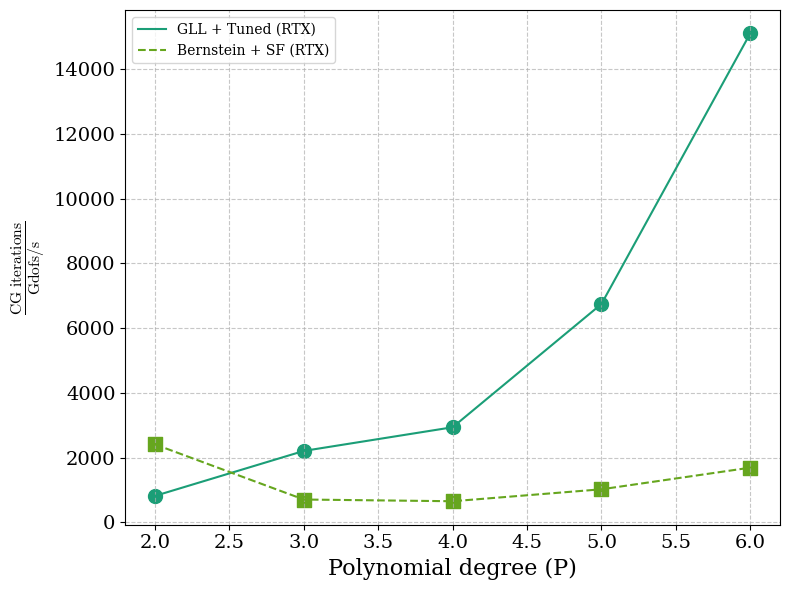

In [11]:
# Plot: CG iterations / gdofs/s = [CGdofs * s]
# For baseline algorithm, GLL and Bernstein are available. The best is always GLL.
# For SF, SF_OTF, only Bernstein is available

from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

fig, axes = plt.subplots(1, 1, figsize=(8, 6))
markers = ['o', 's', '^', 'D', 'x']
# Use a different colormap with more distinct colors for hardware types
colors = plt.cm.Dark2(np.linspace(0, 1, len(HARDWARES)))

# Collect all y values to determine common y limits
all_y_values = []

# Plot for float32
# ax = axes[0]
ax = axes
float32_df = perf_df[perf_df['ScalarType'] == 'float32']

# Create an inset for zoomed view
# axins1 = inset_axes(ax, width="80%", height="40%", loc='center left')

# For each hardware type
for hw_idx, hardware in enumerate(HARDWARES):
    hw_df = float32_df[float32_df['Hardware'] == hardware]
    
    # For GLL with baseline (best baseline scenario)
    gll_baseline_vals = []
    for p_val in P:
        gll_cg = cg_df.loc[cg_df['P'] == p_val, 'GLL_CG'].values[0]
        hw_p_df = hw_df[hw_df['P'] == p_val]
        if len(hw_p_df) > 0 and not np.isnan(gll_cg):
            baseline = hw_p_df['SF_OTF'].values[0]
            if not (np.isnan(gll_cg) or np.isnan(baseline)):
                y_val = gll_cg / baseline
                all_y_values.append(y_val)
                gll_baseline_vals.append((p_val, y_val))
    
    # Plot points and line if we have data
    if gll_baseline_vals:
        p_vals, y_vals = zip(*gll_baseline_vals)
        ax.scatter(p_vals, y_vals, color=colors[0], marker=markers[0], s=100)
        ax.plot(p_vals, y_vals, color=colors[0], 
                label=f'GLL + Tuned ({hardware})', linestyle='-')
        
        # Also plot on inset axes
        # axins1.scatter(p_vals, y_vals, color=colors[hw_idx], marker=markers[0], s=40)
        # axins1.plot(p_vals, y_vals, color=colors[hw_idx], linestyle='-')
    
    # For Bernstein with different approaches
    methods = [
        # ('Bernstein_CG', 'Baseline', 'Bernstein + Baseline'),
        ('Bernstein_PCG', 'SF', 'Bernstein + SF'),
        # ('Bernstein_PCG', 'SF_OTF', 'Bernstein + SF_OTF')
    ]
    
    for method_idx, (cg_col, perf_col, method_label) in enumerate(methods, 1):
        method_vals = []
        for p_val in P:
            cg_val = cg_df.loc[cg_df['P'] == p_val, cg_col].values[0]
            hw_p_df = hw_df[hw_df['P'] == p_val]
            if len(hw_p_df) > 0 and not np.isnan(cg_val):
                perf_val = hw_p_df[perf_col].values[0]
                if not (np.isnan(cg_val) or np.isnan(perf_val)):
                    y_val = cg_val / perf_val
                    all_y_values.append(y_val)
                    method_vals.append((p_val, y_val))
        
        # Plot points and line if we have data
        if method_vals:
            p_vals, y_vals = zip(*method_vals)
            marker_style = markers[1]
            ax.scatter(p_vals, y_vals, color=colors[1], marker=marker_style, s=100)
            ax.plot(p_vals, y_vals, color=colors[1], 
                    label=f'{method_label} ({hardware})', linestyle='--')
            
            # Also plot on inset axes
            # axins1.scatter(p_vals, y_vals, color=colors[hw_idx], marker=marker_style, s=40)
            # axins1.plot(p_vals, y_vals, color=colors[hw_idx], linestyle='--')

# ax.set_title('float32', fontsize=14)
ax.set_xlabel('Polynomial degree (P)', fontsize=16)
ax.set_ylabel('$\\frac{\\text{CG iterations}}{\\text{Gdofs/s}}$', fontsize=16)
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend(fontsize=10)

# # Set up the zoom box
# axins1.set_xlim(1.9, 6.1)  # x-limits: P from 2 to 6
# axins1.set_ylim(0, 500)  # y-limits: 0 to 500
# axins1.grid(True, linestyle='--', alpha=0.7)
# axins1.set_xticklabels('')  # Remove tick labels
# axins1.set_yticklabels('')
# # Draw box showing the zoomed region
# mark_inset(ax, axins1, loc1=2, loc2=4, fc="none", ec="0.5")

# # Plot for float64
# ax = axes[1]
# float64_df = perf_df[perf_df['ScalarType'] == 'float64']

# # Create an inset for zoomed view (float64)
# axins2 = inset_axes(ax, width="80%", height="40%", loc='center left')

# # For each hardware type
# for hw_idx, hardware in enumerate(HARDWARES):
#     hw_df = float64_df[float64_df['Hardware'] == hardware]
    
#     # For GLL with baseline (best baseline scenario)
#     gll_baseline_vals = []
#     for p_val in P:
#         gll_cg = cg_df.loc[cg_df['P'] == p_val, 'GLL_CG'].values[0]
#         hw_p_df = hw_df[hw_df['P'] == p_val]
#         if len(hw_p_df) > 0 and not np.isnan(gll_cg):
#             baseline = hw_p_df['Baseline'].values[0]
#             if not (np.isnan(gll_cg) or np.isnan(baseline)):
#                 y_val = gll_cg  / baseline
#                 all_y_values.append(y_val)
#                 gll_baseline_vals.append((p_val, y_val))
    
#     # Plot points and line if we have data
#     if gll_baseline_vals:
#         p_vals, y_vals = zip(*gll_baseline_vals)
#         ax.scatter(p_vals, y_vals, color=colors[hw_idx], marker=markers[0], s=100)
#         ax.plot(p_vals, y_vals, color=colors[hw_idx], 
#                 label=f'GLL + Baseline ({hardware})', linestyle='-')
        
#         # Also plot on inset axes
#         axins2.scatter(p_vals, y_vals, color=colors[hw_idx], marker=markers[0], s=40)
#         axins2.plot(p_vals, y_vals, color=colors[hw_idx], linestyle='-')
    
#     # For Bernstein with different approaches
#     for method_idx, (cg_col, perf_col, method_label) in enumerate(methods, 1):
#         method_vals = []
#         for p_val in P:
#             cg_val = cg_df.loc[cg_df['P'] == p_val, cg_col].values[0]
#             hw_p_df = hw_df[hw_df['P'] == p_val]
#             if len(hw_p_df) > 0 and not np.isnan(cg_val):
#                 perf_val = hw_p_df[perf_col].values[0]
#                 if not (np.isnan(cg_val) or np.isnan(perf_val)):
#                     y_val = cg_val / perf_val
#                     all_y_values.append(y_val)
#                     method_vals.append((p_val, y_val))
        
#         # Plot points and line if we have data
#         if method_vals:
#             p_vals, y_vals = zip(*method_vals)
#             marker_style = markers[method_idx]
#             ax.scatter(p_vals, y_vals, color=colors[hw_idx], marker=marker_style, s=100)
#             ax.plot(p_vals, y_vals, color=colors[hw_idx], 
#                     label=f'{method_label} ({hardware})', linestyle='--')
                    
#             # Also plot on inset axes
#             axins2.scatter(p_vals, y_vals, color=colors[hw_idx], marker=marker_style, s=40)
#             axins2.plot(p_vals, y_vals, color=colors[hw_idx], linestyle='--')

# ax.set_title('float64', fontsize=14)
# ax.set_xlabel('Polynomial degree (P)')
# ax.set_ylabel('$\\frac{\\text{CG iterations}}{\\text{Gdofs/s}}$')
# ax.grid(True, linestyle='--', alpha=0.7)
# ax.legend(fontsize=10)

# # Set up the zoom box for float64
# axins2.set_xlim(1.9, 6.1)  # x-limits: P from 2 to 6
# axins2.set_ylim(0, 500)  # y-limits: 0 to 500
# axins2.grid(True, linestyle='--', alpha=0.7)
# axins2.set_xticklabels('')
# axins2.set_yticklabels('')
# # Draw box showing the zoomed region
# mark_inset(ax, axins2, loc1=2, loc2=4, fc="none", ec="0.5")

# # Set the same y-limits for both plots
# all_y_values = [y for y in all_y_values if not np.isnan(y)]
# if all_y_values:
#     y_min = min(all_y_values)
#     y_max = max(all_y_values)
#     # Add some padding
#     y_range = y_max - y_min
#     y_min = max(0, y_min - 0.05 * y_range)  # Ensure we don't go below zero
#     y_max = y_max + 0.05 * y_range
    
#     for ax in axes:
#         ax.set_ylim(y_min, y_max)

plt.tight_layout()
plt.savefig('cg_itsdofs_3d.png', dpi=300, bbox_inches='tight')

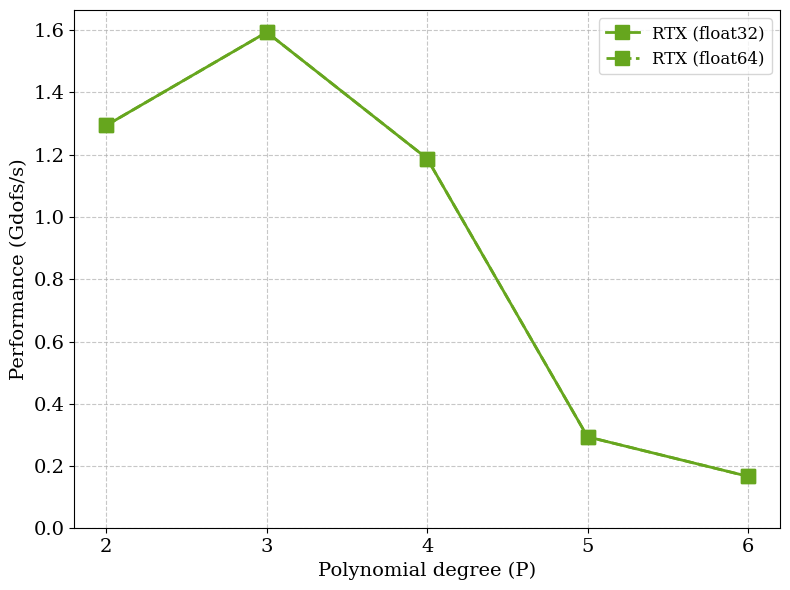

In [9]:
# Create a plot for performance (Gdofs/s) vs polynomial degree
fig, ax = plt.subplots(figsize=(8, 6))

markers = ['o', 's', '^', 'D', 'x']
linestyles = ['-', '--', '-.', ':']

# Create a color map with enough distinct colors
colors = plt.cm.Dark2(np.linspace(0, 1, len(HARDWARES)))

# Track all combinations of hardware and scalar type for the legend
combinations = []

# For each hardware type
for hw_idx, hardware in enumerate(HARDWARES):
    # For each scalar type
    for sc_idx, scalar_type in enumerate(SCALAR_TYPES):
        # Filter the DataFrame for this hardware and scalar type
        subset_df = perf_df[(perf_df['Hardware'] == hardware) & 
                           (perf_df['ScalarType'] == scalar_type)]
        
        if not subset_df.empty:
            # Get the baseline performance for each P value
            p_values = []
            baseline_values = []
            
            for p_val in P:
                p_data = subset_df[subset_df['P'] == p_val]
                if not p_data.empty and not p_data['Baseline'].isna().all():
                    p_values.append(p_val)
                    baseline_values.append(p_data['Baseline'].values[0])
            
            # Plot if we have data
            if p_values:
                linestyle = linestyles[sc_idx % len(linestyles)]
                marker = markers[hw_idx % len(markers)]
                color = colors[hw_idx]
                
                label = f"{hardware} ({scalar_type})"
                combinations.append(label)
                
                ax.plot(p_values, baseline_values, 
                        marker=marker, linestyle=linestyle, color=color,
                        linewidth=2, markersize=10, label=label)

# Add labels and title
ax.set_xlabel('Polynomial degree (P)', fontsize=14)
ax.set_ylabel('Performance (Gdofs/s)', fontsize=14)
ax.grid(True, linestyle='--', alpha=0.7)

# Add legend
ax.legend(fontsize=12, loc='best')

# Set y-axis to start at 0
ax.set_ylim(bottom=0)

# Add x-ticks at each polynomial degree
ax.set_xticks(P)

plt.tight_layout()
plt.savefig('3d_perf.png', dpi=300, bbox_inches='tight')


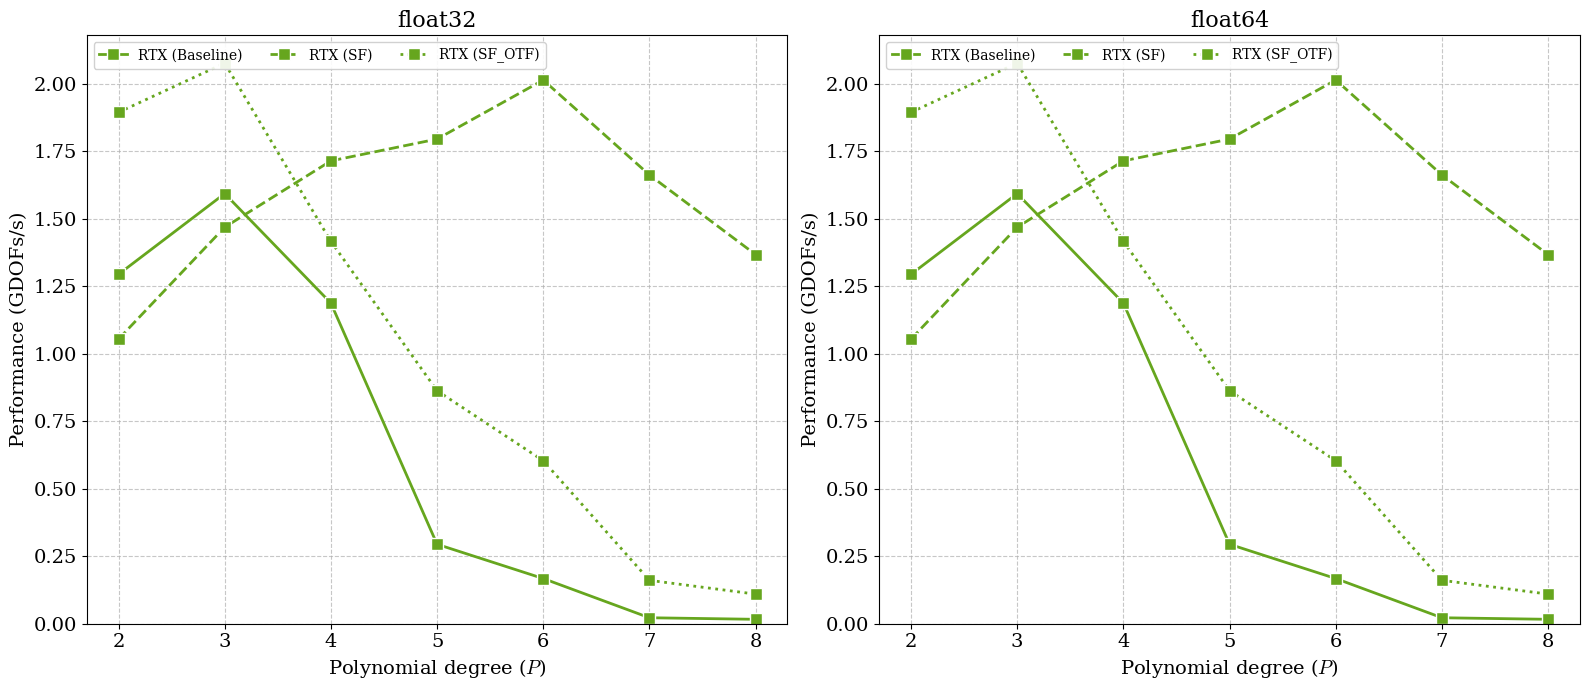

In [33]:
# Create two plots for performance (Gdofs/s) for different algorithms
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

markers = ['o', 's', '^', 'D', 'x']
linestyles = ['-', '--', ':']  # Different line styles for different algorithms
algorithm_colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Distinct colors for algorithms

# Performance metrics to plot
metrics = ['Baseline', 'SF', 'SF_OTF']

# Loop through the two plots (float32, float64)
for idx, scalar_type in enumerate(SCALAR_TYPES):
    ax = axes[idx]
    
    # Filter data for this scalar type
    scalar_df = perf_df[perf_df['ScalarType'] == scalar_type]
    
    # For each hardware type
    for hw_idx, hardware in enumerate(HARDWARES):
        hw_df = scalar_df[scalar_df['Hardware'] == hardware]
        
        # For each performance metric (Baseline, SF, SF_OTF)
        for metric_idx, metric in enumerate(metrics):
            p_values = []
            perf_values = []
            
            # Collect data points
            for p_val in P:
                p_data = hw_df[hw_df['P'] == p_val]
                if not p_data.empty and not p_data[metric].isna().all():
                    p_values.append(p_val)
                    perf_values.append(p_data[metric].values[0])
            
            # Plot if we have data
            if p_values:
                # Use different line style for each algorithm
                linestyle = linestyles[metric_idx % len(linestyles)]
                # Use different marker for each hardware
                marker = markers[hw_idx % len(markers)]
                # Use hardware-specific color
                color = colors[hw_idx]
                
                label = f"{hardware} ({metric})"
                
                # Plot with appropriate styling
                ax.plot(p_values, perf_values, 
                        marker=marker, linestyle=linestyle, color=color,
                        linewidth=2, markersize=8, label=label,
                        markerfacecolor=color, markeredgecolor='white', markeredgewidth=1)
    
    # Set title and labels
    ax.set_title(f'{scalar_type}', fontsize=16)
    ax.set_xlabel('Polynomial degree ($P$)', fontsize=14)
    ax.set_ylabel('Performance (GDOFs/s)', fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Add x-ticks at each polynomial degree
    ax.set_xticks(P)
    
    # Set y-axis to start at 0
    ax.set_ylim(bottom=0)
    
    # Add legend with better layout
    ax.legend(fontsize=10, loc='upper left', frameon=True, 
              framealpha=0.9, ncol=len(HARDWARES))

plt.tight_layout()
plt.savefig('performance_comparison_2d.png', dpi=300, bbox_inches='tight')
plt.show()

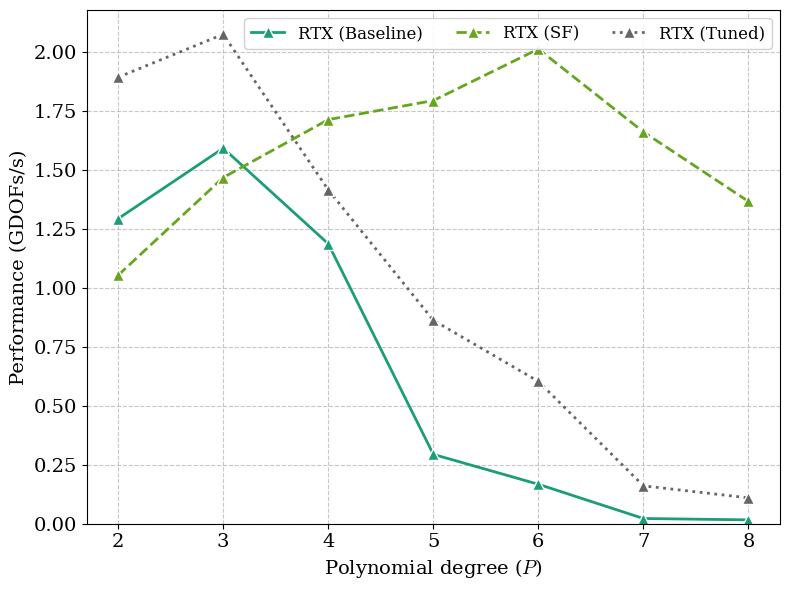

In [36]:
# Create two plots for performance (Gdofs/s) for different algorithms
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

markers = ['o', 's', '^', 'D', 'x']
linestyles = ['-', '--', ':']  # Different line styles for different algorithms
algorithm_colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Distinct colors for algorithms

# Performance metrics to plot
metrics = ['Baseline', 'SF', 'SF_OTF']

hardware = "RTX"
# Loop through the two plots (float32, float64)
# for idx, scalar_type in enumerate(SCALAR_TYPES):

# Filter data for this scalar type
scalar_df = perf_df[perf_df['ScalarType'] == scalar_type]

# For each hardware type
# for hw_idx, hardware in enumerate(HARDWARES):
hw_df = scalar_df[scalar_df['Hardware'] == hardware]

metric_map = {
    'Baseline': 'Baseline',
    'SF': 'SF',
    'SF_OTF': 'Tuned'
}
P = np.arange(2, 9)
    
# For each performance metric (Baseline, SF, SF_OTF)
for metric_idx, metric in enumerate(metrics):
    p_values = []
    perf_values = []
    
    # Collect data points
    for p_val in P:
        p_data = hw_df[hw_df['P'] == p_val]
        if not p_data.empty and not p_data[metric].isna().all():
            p_values.append(p_val)
            perf_values.append(p_data[metric].values[0])
    
    # Plot if we have data
    if p_values:
        # Use different line style for each algorithm
        linestyle = linestyles[metric_idx % len(linestyles)]
        # Use different marker for each hardware
        marker = markers[hw_idx % len(markers)]
        # Use hardware-specific color
        color = colors[metric_idx]
        
        label = f"{hardware} ({metric_map[metric]})"
        
        # Plot with appropriate styling
        ax.plot(p_values, perf_values, 
                marker=marker, linestyle=linestyle, color=color,
                linewidth=2, markersize=8, label=label,
                markerfacecolor=color, markeredgecolor='white', markeredgewidth=1)

# Set title and labels
# ax.set_title(f'{scalar_type}', fontsize=16)
ax.set_xlabel('Polynomial degree ($P$)', fontsize=14)
ax.set_ylabel('Performance (GDOFs/s)', fontsize=14)
ax.grid(True, linestyle='--', alpha=0.7)

# Add x-ticks at each polynomial degree
ax.set_xticks(P)

# Set y-axis to start at 0
ax.set_ylim(bottom=0)

# Add legend with better layout
ax.legend(fontsize=12, loc='best', frameon=True, 
            framealpha=0.9, ncol=len(HARDWARES))

plt.tight_layout()
plt.savefig('performance_comparison_2d.png', dpi=300, bbox_inches='tight')
plt.show()

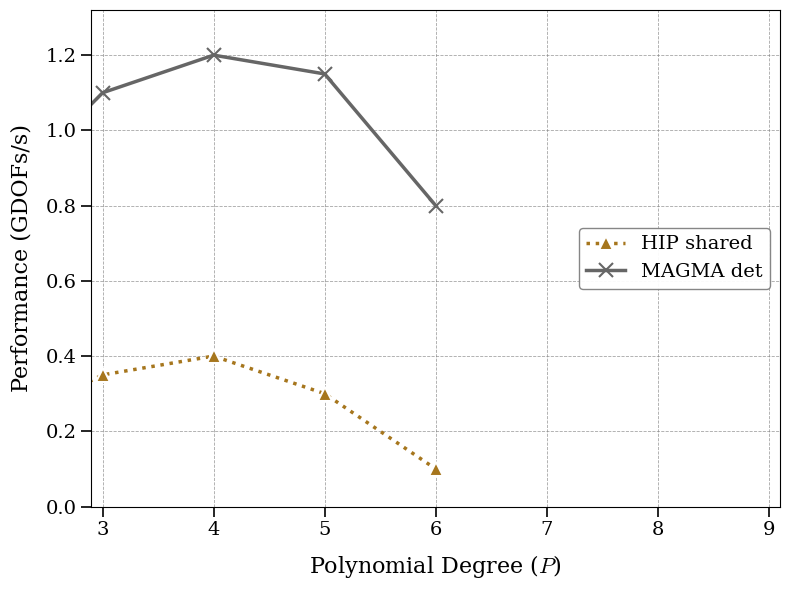

In [27]:
# Create a plot for MI250x 64-bit performance comparing with reference implementations
fig, ax = plt.subplots(figsize=(8, 6))

# Reference data
degrees = [1, 2, 3, 4, 5, 6]
throughput_shared = [0, 200, 350, 400, 300, 100]      # /gpu/hip/shared (MDOFs/s, approx)
throughput_magma_det = [200, 800, 1100, 1200, 1150, 800]  # /gpu/hip/magma/det (MDOFs/s, approx)

# Convert MDOFs/s to GDOFs/s for consistent units
shared_gdofs = [val/1000 for val in throughput_shared]
magma_gdofs = [val/1000 for val in throughput_magma_det]

# Set scientific styling
plt.rcParams.update({
    'font.family': 'serif',
    'mathtext.fontset': 'cm',
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 12
})

# Define styles for all lines
markers = ['o', 's', 'D', '^', 'x']
linestyles = ['-', '--', '-.', ':', '-']
# colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd', '#d62728']  # Add colors for reference data
colors = plt.cm.Dark2(np.linspace(0, 1, 5))

# Filter data for MI250x and float64
filtered_df = perf_df[(perf_df['Hardware'] == 'MI250x') & (perf_df['ScalarType'] == 'float64')]

# Performance metrics to plot
metrics = ['Baseline', 'SF', 'SF_OTF']

# For each performance metric from your data
for metric_idx, metric in enumerate(metrics):
    p_values = []
    perf_values = []
    
    # Collect data points
    for p_val in P:
        p_data = filtered_df[filtered_df['P'] == p_val]
        if not p_data.empty and not p_data[metric].isna().all():
            p_values.append(p_val)
            perf_values.append(p_data[metric].values[0])
    
    # Plot if we have data
    if p_values:
        ax.plot(p_values, perf_values, 
                marker=markers[metric_idx], linestyle=linestyles[metric_idx], 
                color=colors[metric_idx],
                linewidth=2.5, markersize=10, 
                markerfacecolor=colors[metric_idx],
                markeredgecolor='white', markeredgewidth=1.5,
                label=f"{metric}")

# Add the reference data lines
ax.plot(degrees, shared_gdofs, 
        marker=markers[3], linestyle=linestyles[3], 
        color=colors[3],
        linewidth=2.5, markersize=10, 
        markerfacecolor=colors[3],
        markeredgecolor='white', markeredgewidth=1.5,
        label="HIP shared")

ax.plot(degrees, magma_gdofs, 
        marker=markers[4], linestyle=linestyles[4], 
        color=colors[4],
        linewidth=2.5, markersize=10, 
        markerfacecolor=colors[4],
        markeredgewidth=1.5,
        label="MAGMA det")

# Add title and labels with LaTeX formatting
# ax.set_title('MI250x Performance Comparison (float64)', fontsize=18, pad=10)
ax.set_xlabel('Polynomial Degree ($P$)', fontsize=16, labelpad=10)
ax.set_ylabel('Performance (GDOFs/s)', fontsize=16, labelpad=10)

# Improve grid appearance
ax.grid(True, linestyle='--', alpha=0.7, color='gray', linewidth=0.6)

# Set x-ticks at all degrees (both P and reference degrees)
all_degrees = sorted(list(set(P.tolist() + degrees)))
ax.set_xticks(all_degrees)

# Add minor ticks for more precision
ax.minorticks_on()
ax.tick_params(which='major', length=7, width=1.2)

# Set y-axis to start at 0 with room at the top
# Find max value among all datasets
all_values = []
for metric in metrics:
    vals = filtered_df[metric].dropna().tolist()
    all_values.extend(vals)
all_values.extend(shared_gdofs + magma_gdofs)
max_val = max(all_values) if all_values else 1.0

ax.set_xlim(2.9, 9.1)
ax.set_ylim(0, max_val * 1.1)

# Add legend with better styling
legend = ax.legend(fontsize=14, loc='center right', frameon=True,
                   framealpha=0.95, edgecolor='gray', fancybox=True)

P_range = np.arange(3, 10)
ax.set_xticks(P_range)
ax.tick_params(which='minor', bottom=False, left=False)

plt.tight_layout()
plt.savefig('mi250x_float64_comparison.png', dpi=300, bbox_inches='tight')
plt.show()